In [1]:
from PIL import Image
import cv2
import numpy as np
import torch
import gc

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from scripts.inference_i2mv_sdxl import (
    run_pipeline,
    prepare_pipeline
)

/home/sheongee/miniconda3/envs/mvadapter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
NUMVIEWS = 6
#azimuth_deg = [i*(360/NUMVIEWS) for i in range(NUMVIEWS)]
azimuth_deg = [0, 45, 90, 180, 270, 315]
DEVICE = "cuda"

if "pipe" in globals():
	pipe.to("cpu")
	del pipe
	gc.collect()
	torch.cuda.empty_cache()

pipe = prepare_pipeline(
	base_model = "stabilityai/stable-diffusion-xl-base-1.0",
	vae_model = "madebyollin/sdxl-vae-fp16-fix",
	adapter_path = "huanngzh/mv-adapter",
    unet_model = None,
    lora_model = None,
    scheduler = None,
	num_views=NUMVIEWS,
	device=DEVICE,
	dtype=torch.float16,
)


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 47.53 GiB of which 8.81 MiB is free. Process 138714 has 45.08 GiB memory in use. Including non-PyTorch memory, this process has 2.43 GiB memory in use. Of the allocated memory 2.03 GiB is allocated by PyTorch, and 150.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [18]:
pipe = pipe.to(DEVICE)

In [6]:
def my_custom_callback(pipeline, step, timestep, callback_kwargs):
    """매 타임스텝마다 실행되는 사용자 정의 callback 함수"""
    print(f"Step {step}: Timestep {timestep}")

    latent = callback_kwargs.get("latents", None)
    if latent is None:
        return callback_kwargs
    
    # 이미지를 PIL 형식으로 변환
    def save_image_tensor(latents, path):
        latents = latents / pipeline.vae.config.scaling_factor
        with torch.no_grad():
            image_tensors = pipeline.vae.decode(latents.to(pipeline.device)).sample  # [B, C, H, W]
        images = []
        for img in image_tensors:
            img = (img / 2 + 0.5).clamp(0, 1)  # Normalize to [0, 1]
            img = (img * 255).byte().permute(1, 2, 0).cpu().numpy()  # [H, W, C]로 변환
            img_pil = Image.fromarray(img)
            images.append(img_pil)
        
        # 여러 개의 이미지가 있으면 그리드로 저장
        os.makedirs(path, exist_ok=True)
        if len(images) > 1:
            image_grid = make_image_grid(images, rows=1)  # 기존 코드와 동일한 방식
            img_path = os.path.join(path, f"{step}.png")
            image_grid.save(img_path)
        else:
            img_path = os.path.join(path, f"{step}.png")
            images[0].save(img_path)
    
    SAVE_DIR = "out_0"

    #save_image_tensor(latent, f"{SAVE_DIR}_xt")
    #save_image_tensor(pred_x0, f"{SAVE_DIR}_x0")

    return callback_kwargs

In [20]:
IMAGE = "assets/demo/i2mv/dino.png"

images, reference_image = run_pipeline(
    pipe,
    num_views=NUMVIEWS,
    text="",
    image=IMAGE,
    height=768,
    width=768,
    num_inference_steps=50,
    guidance_scale=3.0,
    seed=21,
    lora_scale=1.0,
    reference_conditioning_scale=1.0,
    negative_prompt="watermark, ugly, deformed, noisy, blurry, low contrast",
    device=DEVICE,
    remove_bg_fn=None,
    azimuth_deg=azimuth_deg,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 6.69 MiB is free. Including non-PyTorch memory, this process has 23.67 GiB memory in use. Of the allocated memory 22.67 GiB is allocated by PyTorch, and 672.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [10]:
from mvadapter.utils import (
    draw_patches,
    make_image_grid,
    png_to_gif
)

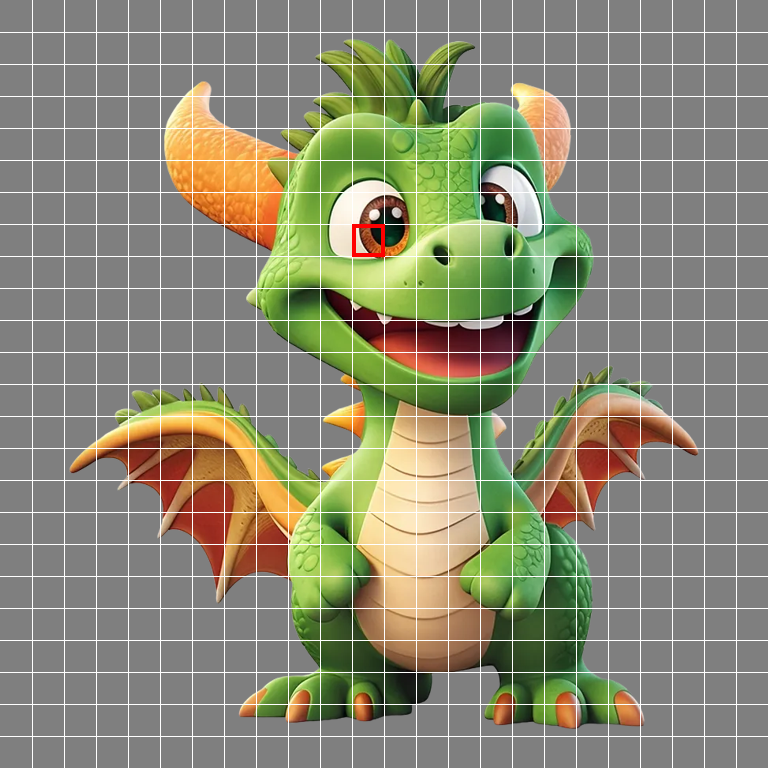

In [10]:
display(draw_patches(reference_image, num_patches=(24, 24), highlight_index=179, line_width=1))

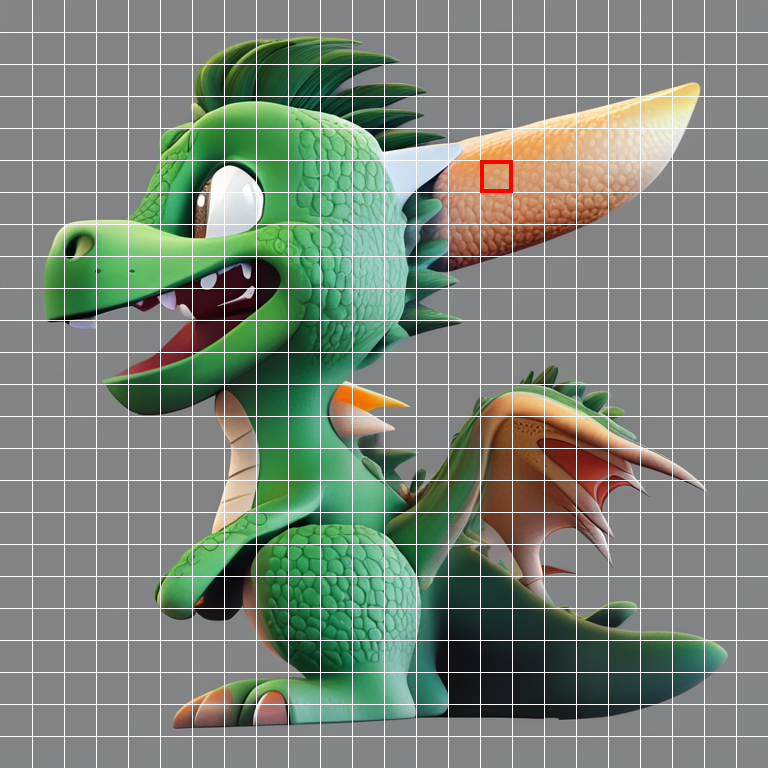

In [11]:
display(draw_patches(images[2], num_patches=(24, 24), highlight_index=135, line_width=1))

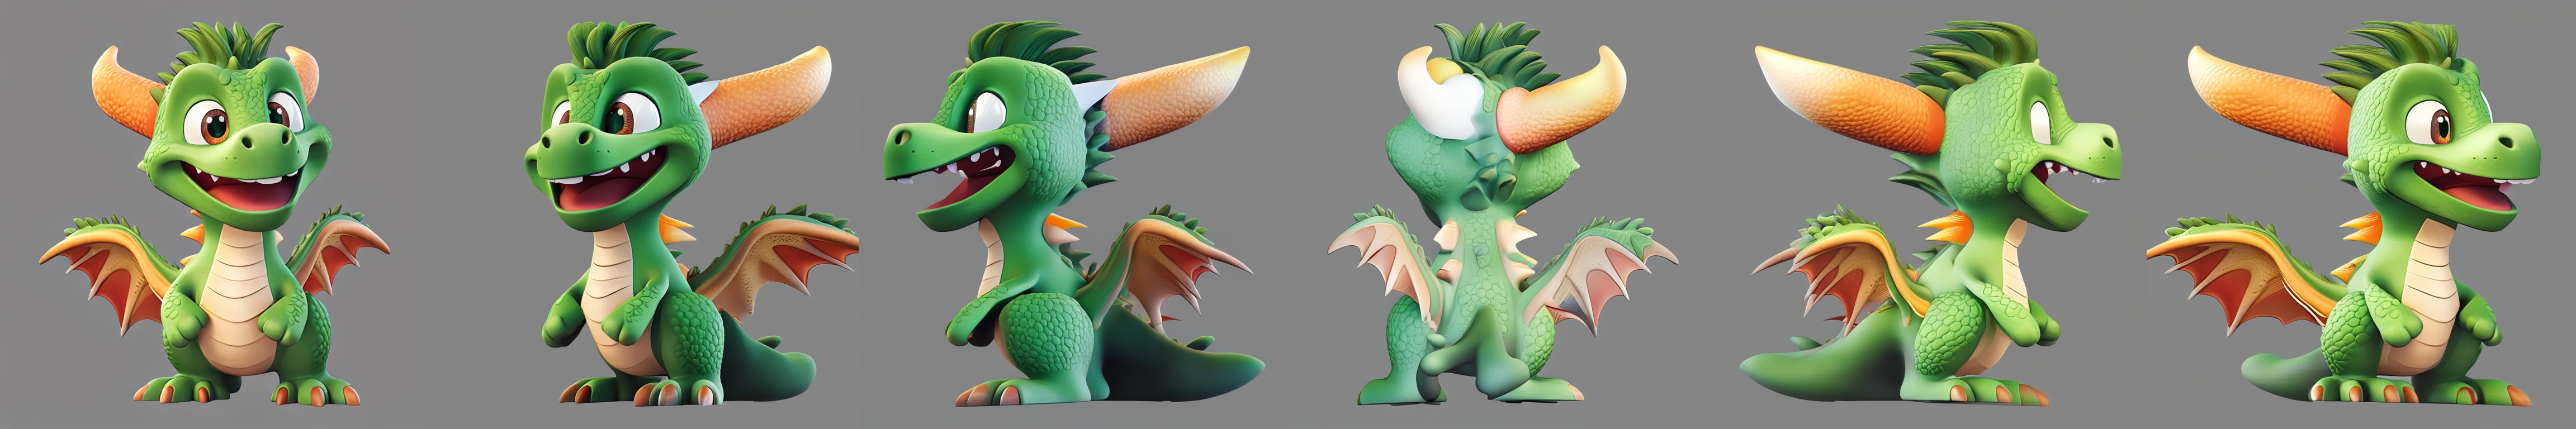

[<PIL.Image.Image image mode=RGB size=768x768 at 0x149F94DB6BF0>, <PIL.Image.Image image mode=RGB size=768x768 at 0x149F94DB7130>, <PIL.Image.Image image mode=RGB size=768x768 at 0x149F94DB6C50>, <PIL.Image.Image image mode=RGB size=768x768 at 0x149F94DB7EB0>, <PIL.Image.Image image mode=RGB size=768x768 at 0x149F94DB7580>, <PIL.Image.Image image mode=RGB size=768x768 at 0x149F94DB6AA0>]


In [12]:
display(make_image_grid(images, rows=1))
print(images)

gif 저장 완료: attn_maps/dino-2-135.gif, filesize:110.52KB


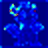

In [14]:
filename = "dino-2-135"
input_folder = f"attn_maps/{filename}"  # PNG 이미지가 있는 폴더 경로
output_gif = f"attn_maps/{filename}.gif"  # 생성할 GIF 파일 경로
png_to_gif(input_folder, output_gif, duration=100, loop=0)